In [9]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

from inference import get_model

ROBOFLOW_API_KEY = 'tCy476DHnSoq6mwGtVpp'
PLAYER_DETECTION_MODEL_ID = 'football-players-detection-3zvbc/2'
PLAYER_DETECTION_MODEL = get_model(PLAYER_DETECTION_MODEL_ID, ROBOFLOW_API_KEY)

In [10]:
SOURCE_VIDEO_PATH = "../data/videos/new-5s.mp4"

import supervision as sv
from tqdm import tqdm

BALL_ID = 0
PLAYER_ID = 1

label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000')
)

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

In [11]:
frames = []

for frame_index, frame in enumerate(sv.get_video_frames_generator(SOURCE_VIDEO_PATH)):
    if frame_index % 25 == 0:  # Save only every 5th frame
        frames.append(frame)

print(f"Total frames collected: {len(frames)}")

Total frames collected: 7


Frame 0


Processing...:   0%|          | 0/7 [00:00<?, ?it/s]

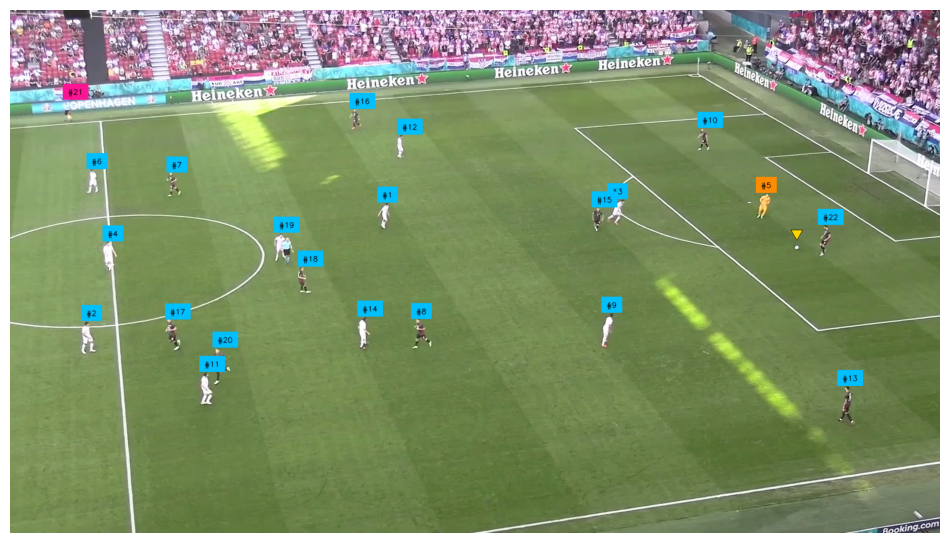

Frame 1


Processing...:  14%|█▍        | 1/7 [00:01<00:09,  1.53s/it]

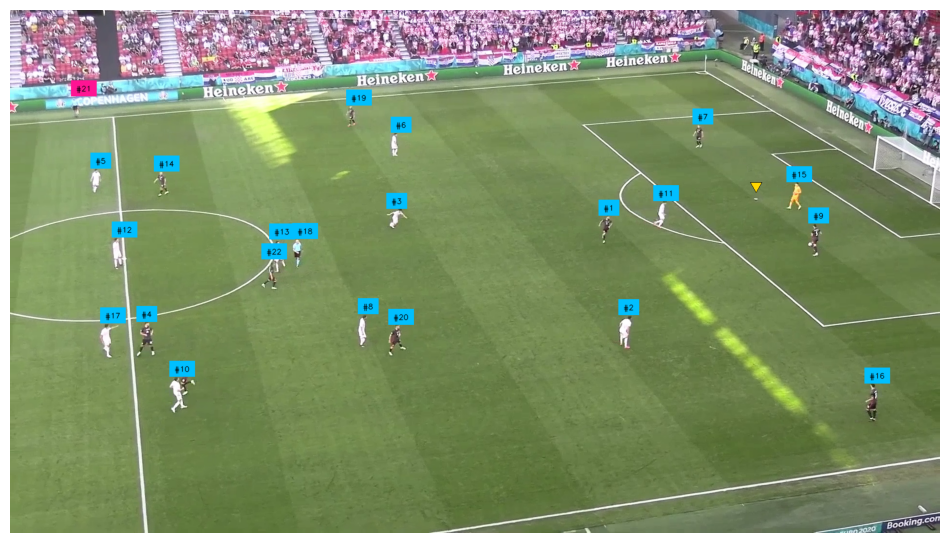

Frame 2


Processing...:  29%|██▊       | 2/7 [00:02<00:07,  1.47s/it]

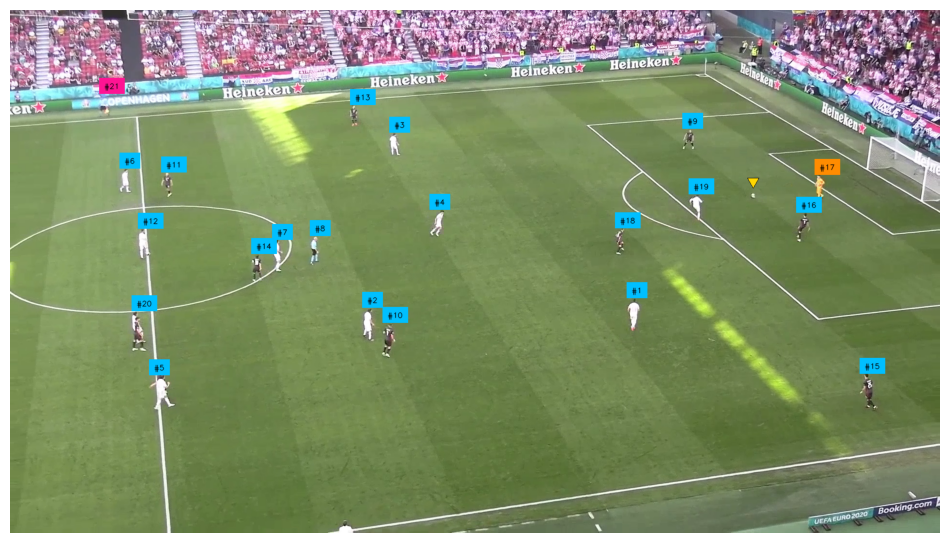

Frame 3


Processing...:  43%|████▎     | 3/7 [00:04<00:06,  1.55s/it]

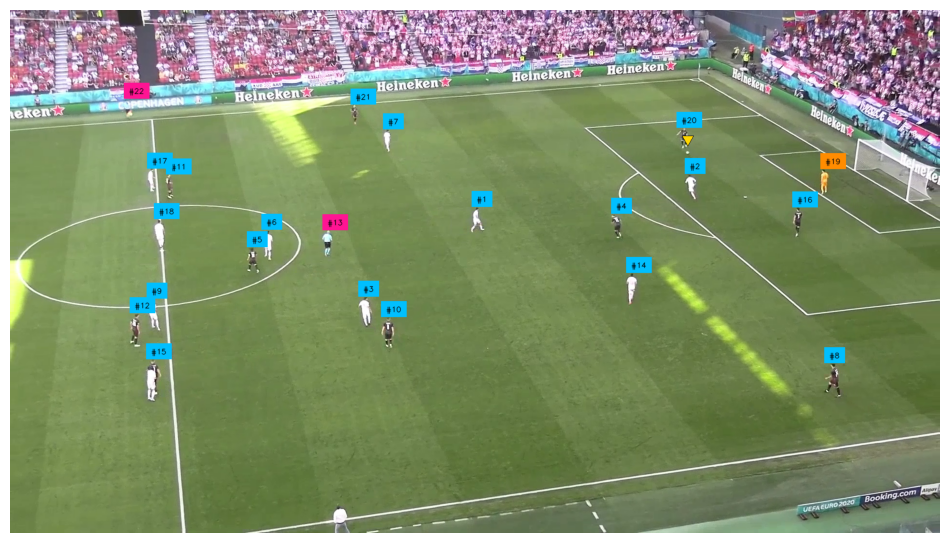

Frame 4


Processing...:  57%|█████▋    | 4/7 [00:06<00:04,  1.57s/it]

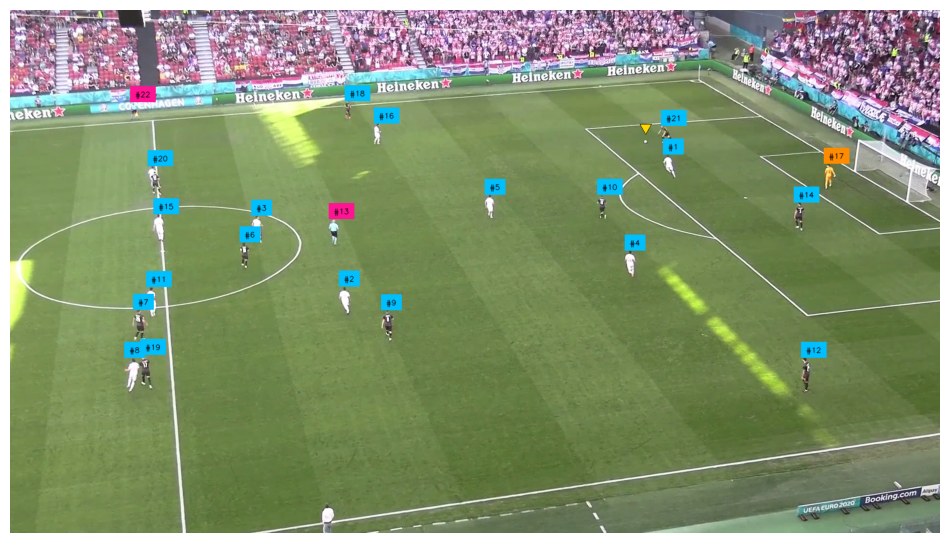

Frame 5


Processing...:  71%|███████▏  | 5/7 [00:08<00:03,  1.66s/it]

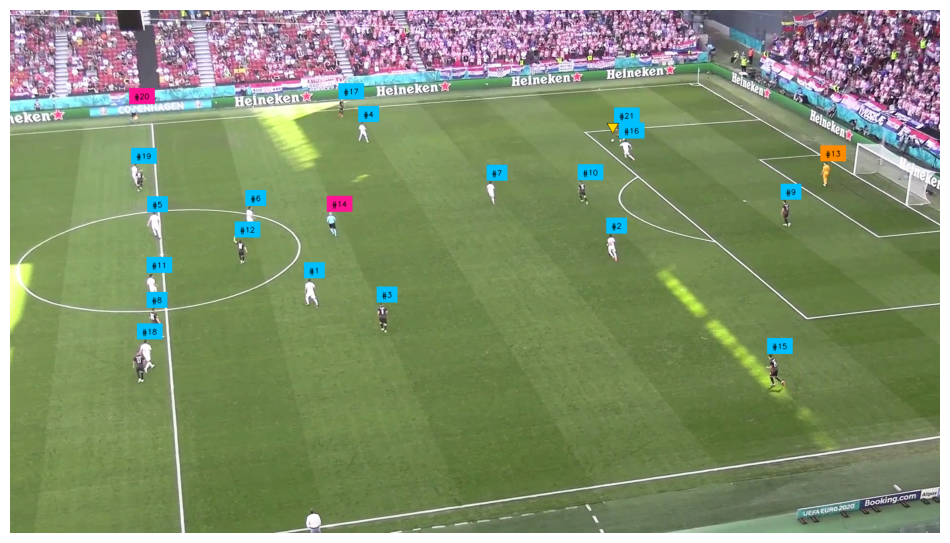

Frame 6


Processing...:  86%|████████▌ | 6/7 [00:09<00:01,  1.66s/it]

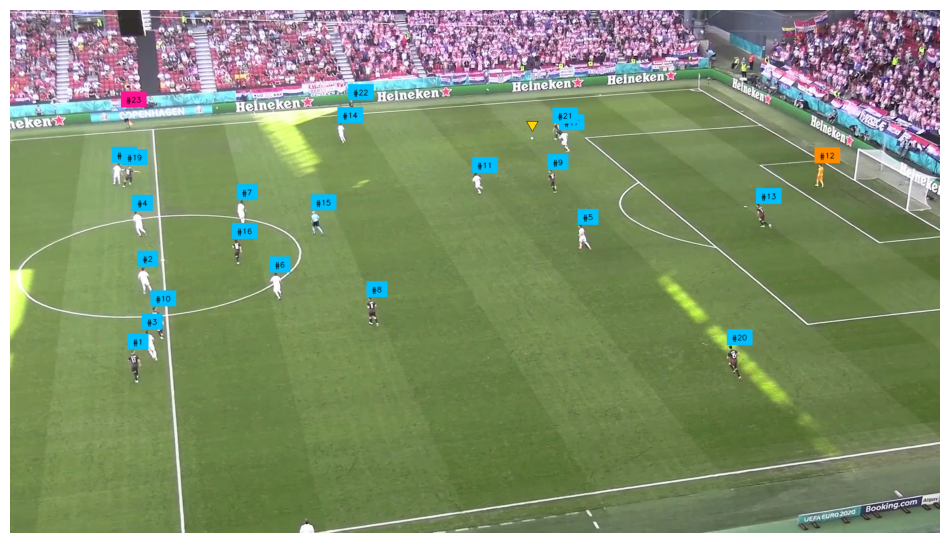

Processing...: 100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


In [12]:
# Annotate the frames with player detection
from custom_bytetracker import CustomByteTrack
annotated_frames = []
positions_by_id = {}

# Replace the tracker with the custom one
#tracker = CustomByteTrack(iou_threshold=0.3)
tracker = sv.ByteTrack()

# Update the loop to use the custom logic
for frame_index, frame in enumerate(tqdm(frames, desc="Processing...")):
    tqdm.write(f"Frame {frame_index}")

    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.7)[0]
    detections = sv.Detections.from_inference(result)

    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

    # Filter out player detections
    player_detections = detections[detections.class_id == PLAYER_ID]
    
    # Use custom tracking logic
    #all_detections = tracker.update_with_custom_logic(detections=all_detections)
    
    all_detections = detections[detections.class_id != BALL_ID]
    all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
    all_detections.class_id -= 1
    all_detections = tracker.update_with_detections(detections=all_detections)
    
    # Extract positions of players + gks
    for tracker_id, bbox in zip(all_detections.tracker_id, all_detections.xyxy):
        center_x = (bbox[0] + bbox[2]) / 2  # (xmin + xmax) / 2
        center_y = (bbox[1] + bbox[3]) / 2  # (ymin + ymax) / 2
        
        if tracker_id not in positions_by_id:
            positions_by_id[tracker_id] = []
        
        # Append frame index and position
        positions_by_id[tracker_id].append((frame_index, center_x, center_y))

    
    labels = [
        f"#{tracker_id}"
        for tracker_id in all_detections.tracker_id
    ]

    annotated_frame = frame.copy()
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame,
        detections=all_detections,
        labels=labels
    )
    annotated_frame = triangle_annotator.annotate(
        scene=annotated_frame,
        detections=ball_detections
    )

    annotated_frames.append(annotated_frame)

    sv.plot_image(annotated_frame)
    
    tracker.reset()

In [13]:
'''
# Print positions for each ID by frame
for tracker_id, positions in positions_by_id.items():
    print(f"ID {tracker_id}:")
    for frame_index, center_x, center_y in positions:
        print(f"  Frame {frame_index}: ({center_x:.2f}, {center_y:.2f})")

'''

'\n# Print positions for each ID by frame\nfor tracker_id, positions in positions_by_id.items():\n    print(f"ID {tracker_id}:")\n    for frame_index, center_x, center_y in positions:\n        print(f"  Frame {frame_index}: ({center_x:.2f}, {center_y:.2f})")\n\n'